# Лабораторная работа №1.  Вариант 4.
## Клименко Виталий Б01-203
### Лабораторная работа 1 Системы ОДУ.

Решить системы ОДУ следующими классами методов:

1) Явные методы Рунге-Кутта от 1 до 4 порядка
2) Явные методы Адамса от 2 до 4 порядка (внимание разгонный участок!)
3) Явные методы Формулы Дифференцирования Назад от 2 до 4 порядка (внимание разгонный участок!)

Формулы явных методов некоторые писали ранее на семинарах, либо в пособиях можно найти, либо загуглить .

Под решением понимается - вывод графика интегральных кривых при заданном h (шаге интегрирования), когда наблюдается устойчивая картина решения - отдельно по семействам методов


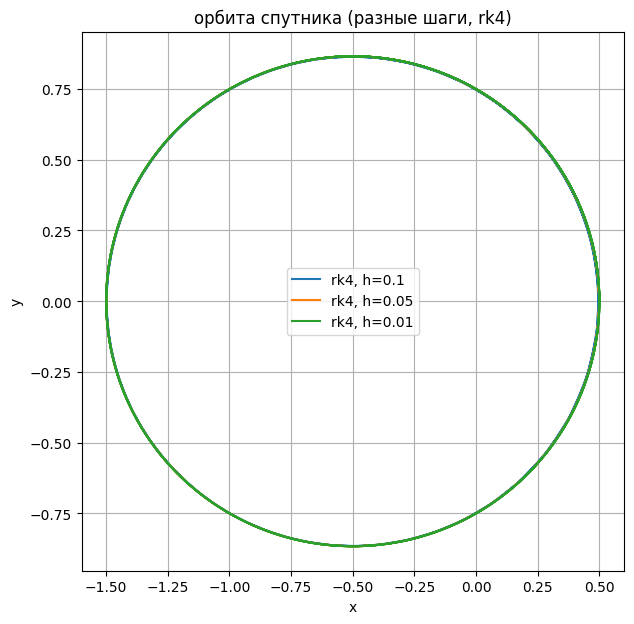

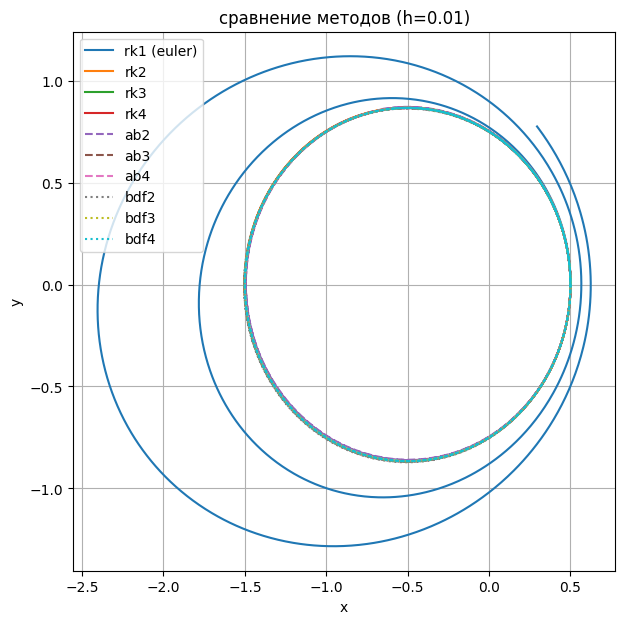

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# функция правых частей
def f(st):
    x, y, z, u = st
    r2 = x**2 + y**2
    r3 = (r2)**1.5
    # если r2 слишком мало, чтобы избежать деления на ноль
    if r2 < 1e-15:
        return np.array([z, u, 0, 0])
    dx = z
    dy = u
    dz = -x / r3
    du = -y / r3
    return np.array([dx, dy, dz, du])

# численный якобиан f
def df_num(f, st, eps=1e-8):
    n = len(st)
    jac = np.zeros((n, n))
    for j in range(n):
        e = np.zeros(n)
        e[j] = eps
        f_plus = f(st + e)
        f_minus = f(st - e)
        jac[:, j] = (f_plus - f_minus)/(2*eps)
    return jac

# метод эйлера (rk1)
def rk1(f, st0, t0, tmax, h):
    n = int((tmax - t0)/h)
    t_vals = np.zeros(n+1)
    sol = np.zeros((n+1, len(st0)))
    sol[0] = st0
    for i in range(n):
        sol[i+1] = sol[i] + h*f(sol[i])
        t_vals[i+1] = t0 + (i+1)*h
    return t_vals, sol

# метод рунге-кутты 2-го порядка
def rk2(f, st0, t0, tmax, h):
    n = int((tmax - t0)/h)
    t_vals = np.zeros(n+1)
    sol = np.zeros((n+1, len(st0)))
    sol[0] = st0
    for i in range(n):
        k1 = f(sol[i])
        k2 = f(sol[i] + h*k1)
        sol[i+1] = sol[i] + 0.5*h*(k1 + k2)
        t_vals[i+1] = t0 + (i+1)*h
    return t_vals, sol

# метод рунге-кутты 3-го порядка
def rk3(f, st0, t0, tmax, h):
    n = int((tmax - t0)/h)
    t_vals = np.zeros(n+1)
    sol = np.zeros((n+1, len(st0)))
    sol[0] = st0
    for i in range(n):
        k1 = f(sol[i])
        k2 = f(sol[i] + 0.5*h*k1)
        k3 = f(sol[i] + h*(-k1 + 2*k2))
        sol[i+1] = sol[i] + (h/6)*(k1 + 4*k2 + k3)
        t_vals[i+1] = t0 + (i+1)*h
    return t_vals, sol

# метод рунге-кутты 4-го порядка
def rk4(f, st0, t0, tmax, h):
    n = int((tmax - t0)/h)
    t_vals = np.zeros(n+1)
    sol = np.zeros((n+1, len(st0)))
    sol[0] = st0
    for i in range(n):
        k1 = f(sol[i])
        k2 = f(sol[i] + 0.5*h*k1)
        k3 = f(sol[i] + 0.5*h*k2)
        k4 = f(sol[i] + h*k3)
        sol[i+1] = sol[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        t_vals[i+1] = t0 + (i+1)*h
    return t_vals, sol

# метод адамса-бэшфорта (2-4 порядок), с разгонным участком rk4
def adams_bashforth(f, st0, t0, tmax, h, m):
    n = int((tmax - t0)/h)
    t_vals = np.zeros(n+1)
    sol = np.zeros((n+1, len(st0)))
    sol[0] = st0
    t_vals[0] = t0

    # разгон rk4
    for i in range(m-1):
        if i >= n:
            break
        k1 = f(sol[i])
        k2 = f(sol[i] + 0.5*h*k1)
        k3 = f(sol[i] + 0.5*h*k2)
        k4 = f(sol[i] + h*k3)
        sol[i+1] = sol[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        t_vals[i+1] = t_vals[i] + h

    # начинаем многошаг
    fvals = [f(sol[j]) for j in range(m-1)]
    for i in range(m-1, n):
        fvals.append(f(sol[i]))
        if len(fvals) > m:
            fvals.pop(0)

        if m == 2:
            sol[i+1] = sol[i] + h*( (3*fvals[-1]) - fvals[-2] )/2
        elif m == 3:
            sol[i+1] = sol[i] + h*( (23*fvals[-1]) -16*fvals[-2] +5*fvals[-3] )/12
        elif m == 4:
            sol[i+1] = sol[i] + h*( (55*fvals[-1]) -59*fvals[-2] +37*fvals[-3] -9*fvals[-4] )/24

        t_vals[i+1] = t_vals[i] + h
    return t_vals, sol

# bdf с ньютонами (2-4 порядок), с разгонным участком rk4
def bdf(f, st0, t0, tmax, h, m, max_iter=15, tol=1e-12):
    n = int((tmax - t0)/h)
    t_vals = np.zeros(n+1)
    sol = np.zeros((n+1, len(st0)))
    sol[0] = st0
    t_vals[0] = t0

    # разгон rk4
    for i in range(m-1):
        if i >= n:
            break
        k1 = f(sol[i])
        k2 = f(sol[i] + 0.5*h*k1)
        k3 = f(sol[i] + 0.5*h*k2)
        k4 = f(sol[i] + h*k3)
        sol[i+1] = sol[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        t_vals[i+1] = t_vals[i] + h

    for i in range(m-1, n):
        y0 = sol[i].copy()

        # коэффициенты bdf
        if m == 2:
            # 3y_{n+1} - 4y_n + y_{n-1} = 2h f(y_{n+1})
            alpha = 3.0
            beta = 2.0
            rhs_part = -4*sol[i] + sol[i-1]
        elif m == 3:
            # 11y_{n+1} -18y_n +9y_{n-1} -2y_{n-2} = 6h f(y_{n+1})
            alpha = 11.0
            beta = 6.0
            rhs_part = -18*sol[i] + 9*sol[i-1] - 2*sol[i-2]
        else:
            # 25y_{n+1} -48y_n +36y_{n-1} -16y_{n-2} +3y_{n-3} = 12h f(y_{n+1})
            alpha = 25.0
            beta = 12.0
            rhs_part = -48*sol[i] +36*sol[i-1] -16*sol[i-2] +3*sol[i-3]

        # функция G(Y) = alpha*Y + rhs_part - beta*h*f(Y)
        # хотим G(Y)=0
        def G(Y):
            return alpha*Y + rhs_part - beta*h*f(Y)

        # G'(Y)= alpha*I - beta*h*df(Y)
        # метод ньютона
        for _ in range(max_iter):
            g_val = G(y0)
            if np.linalg.norm(g_val) < tol:
                break
            jac = df_num(lambda xx: beta*h*f(xx), y0)
            # итоговая матрица = alpha*I - jac
            # потому что G'(Y)= alpha*I - beta*h*df(Y),
            # но мы уже jac сделали для beta*h*f
            A = alpha*np.eye(len(st0)) - jac
            try:
                dy = np.linalg.solve(A, g_val)
            except np.linalg.LinAlgError:
                # если матрица вырождена
                dy = np.zeros_like(y0)
            y0 = y0 - dy

        sol[i+1] = y0
        t_vals[i+1] = t_vals[i] + h

    return t_vals, sol

# пример: задача двух тел
x0 = 0.5
y0 = 0.0
z0 = 0.0
u0 = np.sqrt(3.0)
st0 = np.array([x0, y0, z0, u0])

t0 = 0.0
tmax = 20.0

# посмотрим рк4 с разными шагами
h_values = [0.1, 0.05, 0.01]
plt.figure(figsize=(7,7))
for hh in h_values:
    t_rk4, s_rk4 = rk4(f, st0, t0, tmax, hh)
    plt.plot(s_rk4[:,0], s_rk4[:,1], label=f'rk4, h={hh}')
plt.title('орбита спутника (разные шаги, rk4)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# сравним методы при одном шаге
h_demo = 0.01
t_e, s_e = rk1(f, st0, t0, tmax, h_demo)
t_2, s_2 = rk2(f, st0, t0, tmax, h_demo)
t_3, s_3 = rk3(f, st0, t0, tmax, h_demo)
t_4, s_4 = rk4(f, st0, t0, tmax, h_demo)

t_ab2, s_ab2 = adams_bashforth(f, st0, t0, tmax, h_demo, 2)
t_ab3, s_ab3 = adams_bashforth(f, st0, t0, tmax, h_demo, 3)
t_ab4, s_ab4 = adams_bashforth(f, st0, t0, tmax, h_demo, 4)

t_bdf2, s_bdf2 = bdf(f, st0, t0, tmax, h_demo, 2)
t_bdf3, s_bdf3 = bdf(f, st0, t0, tmax, h_demo, 3)
t_bdf4, s_bdf4 = bdf(f, st0, t0, tmax, h_demo, 4)

plt.figure(figsize=(7,7))
plt.plot(s_e[:,0], s_e[:,1], label='rk1 (euler)')
plt.plot(s_2[:,0], s_2[:,1], label='rk2')
plt.plot(s_3[:,0], s_3[:,1], label='rk3')
plt.plot(s_4[:,0], s_4[:,1], label='rk4')
plt.plot(s_ab2[:,0], s_ab2[:,1], '--', label='ab2')
plt.plot(s_ab3[:,0], s_ab3[:,1], '--', label='ab3')
plt.plot(s_ab4[:,0], s_ab4[:,1], '--', label='ab4')
plt.plot(s_bdf2[:,0], s_bdf2[:,1], ':', label='bdf2')
plt.plot(s_bdf3[:,0], s_bdf3[:,1], ':', label='bdf3')
plt.plot(s_bdf4[:,0], s_bdf4[:,1], ':', label='bdf4')
plt.title('сравнение методов (h=0.01)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


# Заключение

Взяли явные методы Рунге–Кутты (порядка от 1 до 4) и явные многошаговые схемы Адамса.  
У таких задач нет сильной жёсткости, поэтому явные методы дают хорошие результаты даже при относительно крупном шаге. Но при слишком большом шаге решение «расплывается».
